# Thematic differences GB

DHH23 Parliament group

Author: Pontus H.

Conservatives + Liberal Democrats: 11.05.2010 – 08.05.2015 (Cameron–Clegg coalition)

Conservatives: 08.05.2015 – 13.07.2016 (Second Cameron ministry)

Conservatives: 13.07.2016 – 11.07.2017 (First May Ministry)

Conservatives: 11.07.2017 – 24.07.2019 (Second May Ministry)

Conservatives: 24.07.2019 – 16.12.2019 (First Johnson Ministry)

Conservatives: 16.12.2019 – 06.09.2022 (Second Johnson Ministry)

In [155]:
# Set the theme here
THEME = 'gender_GB'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [156]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

Set up the BERTopic pipeline

In [157]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 50
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [158]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-GB_2017-11-20-commons.u520,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Morgan, Nicky",F,-,I am grateful to be granted this Adjournment d...,I was therefore pleased to publish the Govern...,0.711426,2168
1,ParlaMint-GB_2017-11-20-commons.u522,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Morgan, Nicky",F,-,I thank my hon. Friend very much for that. I a...,Friend very much for that. I am going on to s...,0.693848,446
2,ParlaMint-GB_2017-11-20-commons.u524,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"Morgan, Nicky",F,-,I agree very much with what the hon. Gentleman...,"Gentleman says, and I know that he is a great...",0.515137,9435
3,ParlaMint-GB_2017-11-20-commons.u525,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"James, Margot Cathleen",F,-,I thank my right hon. Friend the Member for Lo...,Friend the Member for Loughborough (Nicky Mor...,0.797363,5917
4,ParlaMint-GB_2017-11-20-commons.u527,"Minutes of the House of Commons, Daily Session...",2017-11-20,Lower house,57,NaN,NaN,2017-11-20,NaN,Reference,...,CON,Conservative,NaN,"James, Margot Cathleen",F,-,I will certainly consider what my right hon. F...,Friend said; she certainly makes a powerful c...,0.735840,797


In [159]:
# Reference running time for this cell: 37s
topics, probs = topic_model.fit_transform(df['speech'])


In [160]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.05)

In [161]:
pd.Series(new_topics).value_counts()

 0     748
 1     689
 2     333
 3     303
 5     250
 4     248
 7     203
 6     193
 8     172
 9     127
 10    110
 11     92
 15     82
 12     72
 13     59
 14     57
-1       2
dtype: int64

In [162]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [163]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [164]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
print(f"Number of topics before: {len(pd.Series(new_topics).unique())}")

Number of topics before: 17
Number of topics before: 17


In [165]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     773
 0     625
 13    469
 1     275
 3     271
 8     224
 15    160
 9     156
 6     153
 14    131
 10     99
 11     87
 2      87
 12     65
 4      58
 7      54
 5      53
dtype: int64

In [166]:
topic_model.visualize_topics()

Topics over time

In [167]:
# Reference running time for this cell: 2min 30s
topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [168]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [169]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [170]:
# Brexit
topics_over_time[topics_over_time['Topic'] == 0]

,Topic,Words,Frequency,Timestamp,Name
1,0,"prayers, families, settings, coroners, matilda",6,2015-01-02 05:54:14.400,0_lgbt_rights_ireland_human
14,0,"detained, dungavel, yarl, alternatives, wood",14,2015-05-22 16:48:00.000,0_lgbt_rights_ireland_human
26,0,"couples, opposite, burundi, stability, armed",21,2015-10-07 09:36:00.000,0_lgbt_rights_ireland_human
43,0,"anglican, lichfield, idahot, festivities, rainbow",21,2016-02-22 02:24:00.000,0_lgbt_rights_ireland_human
59,0,"turing, alan, lgbt, pardoned, today",45,2016-07-08 19:12:00.000,0_lgbt_rights_ireland_human
74,0,"statute, maritime, partnerships, forces, sections",43,2016-11-23 12:00:00.000,0_lgbt_rights_ireland_human
90,0,"chechnya, ireland, foreign, sinn, rights",31,2017-04-10 04:48:00.000,0_lgbt_rights_ireland_human
104,0,"torture, egypt, chechnya, arundel, commonwealth",51,2017-08-25 21:36:00.000,0_lgbt_rights_ireland_human
121,0,"lgbt, bermuda, partnerships, ireland, married",82,2018-01-10 14:24:00.000,0_lgbt_rights_ireland_human
138,0,"tobacco, ireland, lgbt, stables, plan",25,2018-05-28 07:12:00.000,0_lgbt_rights_ireland_human


In [171]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

Save relevant speeches from a particular subtopic

In [172]:
# Get the most relevant speeches from a topic and save to a text file

def save_topic_speeches(topic_id):
    speeches = topic_model.get_representative_docs(topic_id)
    with open(f"{OUTPUT_PATH}{THEME}_topic{topic_id}_speeches.txt", "w", encoding="utf-8") as file:
        file.write(f"Relevant speeches for theme {THEME} and topic {topic_id}\n\n")
        for speech in speeches:
            file.write(speech)
            file.write("\n\n")
for topic_id in range(10):
    save_topic_speeches(topic_id)

# Word Clouds

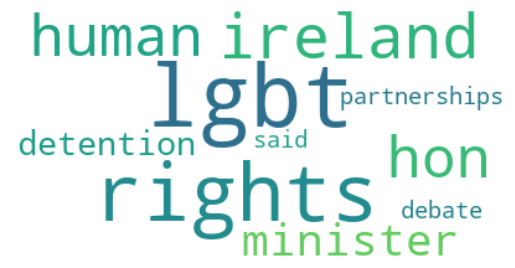

In [173]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [174]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [175]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['lgbt',
 'rights',
 'ireland',
 'human',
 'hon',
 'minister',
 'detention',
 'partnerships',
 'said',
 'debate']

In [176]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Set the party name to 'OTHER' if the party name does not contain 'CON', 'LAB' or 'SNP'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('CON|LAB|SNP'), 'party'] = 'OTHER'
# Set the party name to CON if the party name contains 'CON'
speech_topic_party.loc[speech_topic_party['party'].str.contains('CON'), 'party'] = 'CON'
# Set the party name to SNP if the party name contains 'SNP'
speech_topic_party.loc[speech_topic_party['party'].str.contains('SNP'), 'party'] = 'SNP'
# Set the party name to LAB if the party name contains 'LAB'
speech_topic_party.loc[speech_topic_party['party'].str.contains('LAB'), 'party'] = 'LAB'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,CON,LAB,OTHER,SNP
topic,,,,
0,334,248,41,125
1,434,173,27,55
2,174,101,11,47
3,152,86,21,44
4,118,96,9,25
5,124,79,7,40
6,96,77,9,11
7,84,75,11,33
8,75,67,7,23


In [177]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,CON,LAB,OTHER,SNP
topic,,,,
0,20.4,23.5,27.2,29.7
1,26.5,16.4,17.9,13.1
2,10.6,9.6,7.3,11.2
3,9.3,8.2,13.9,10.5
4,7.2,9.1,6.0,5.9
5,7.6,7.5,4.6,9.5
6,5.9,7.3,6.0,2.6
7,5.1,7.1,7.3,7.8
8,4.6,6.4,4.6,5.5


In [178]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,CON,LAB,OTHER,SNP,keywords
topic,,,,,
0,20.4,23.5,27.2,29.7,"[lgbt, rights, ireland, human, hon, minister, ..."
1,26.5,16.4,17.9,13.1,"[gap, employers, reporting, equality, hon, tra..."
2,10.6,9.6,7.3,11.2,"[transgender, recognition, care, prisoners, 20..."
3,9.3,8.2,13.9,10.5,"[victims, sexual, convention, based, istanbul,..."
4,7.2,9.1,6.0,5.9,"[member, friend, armed, jo, building, constitu..."
5,7.6,7.5,4.6,9.5,"[woman, international, hon, celebrate, friend,..."
6,5.9,7.3,6.0,2.6,"[young, guidance, primary, sre, people, birmin..."
7,5.1,7.1,7.3,7.8,"[trade, climate, european, junior, referendum,..."
8,4.6,6.4,4.6,5.5,"[women, tax, impact, chancellor, gap, policies..."


In [179]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,CON,LAB,OTHER,SNP
0,0,44.7,33.2,5.5,16.7
1,1,63.0,25.1,3.9,8.0
2,2,52.3,30.3,3.3,14.1
3,3,50.2,28.4,6.9,14.5
4,4,47.6,38.7,3.6,10.1
5,5,49.6,31.6,2.8,16.0
6,6,49.7,39.9,4.7,5.7
7,7,41.4,36.9,5.4,16.3
8,8,43.6,39.0,4.1,13.4
9,9,37.8,41.7,6.3,14.2


Calculate mean sentiment for each topic per party

In [180]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Set the party name to 'OTHER' if the party name does not contain 'CON', 'LAB' or 'SNP'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('CON|LAB|SNP'), 'party'] = 'OTHER'
# Set the party name to CON if the party name contains 'CON'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('CON'), 'party'] = 'CON'
# Set the party name to SNP if the party name contains 'SNP'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('SNP'), 'party'] = 'SNP'
# Set the party name to LAB if the party name contains 'LAB'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('LAB'), 'party'] = 'LAB'
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,CON,LAB,OTHER,SNP
topic,,,,
0,0.18,-0.12,-0.13,-0.12
1,0.28,-0.26,-0.13,-0.32
2,0.24,-0.10,-0.52,-0.03
3,-0.07,-0.34,-0.35,-0.04
4,0.42,0.38,0.52,0.38
5,0.39,0.18,0.23,0.09
6,0.19,-0.25,-0.14,-0.08
7,0.37,-0.19,-0.58,0.05
8,0.20,-0.33,-0.05,-0.29


In [181]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")